모듈 import

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

블럭 생성

In [3]:
def gen_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

def dis_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

생성자

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            gen_block(z_dim, hidden_dim),
            gen_block(hidden_dim, hidden_dim*2),
            gen_block(hidden_dim*2, hidden_dim*4),
            gen_block(hidden_dim*4, hidden_dim*8),
            
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )
        
    def forward(self, noise): return self.gen(noise)

    def get_gen(self): return self.gen

판별자

In [5]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            dis_block(im_dim, hidden_dim * 4),
            dis_block(hidden_dim * 4, hidden_dim * 2),
            dis_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image): return self.disc(image)

    def get_disc(self): return self.disc

노이즈 추가

In [6]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

초기화

In [8]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cpu'

데이터 로드

In [9]:
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
    )

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Optimizer

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

GAN Loss

In [11]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, divice):
    fake_noise = get_noise(num_images, z_dim, device=device) # z
    fake = gen(fake_noise) # G(z)
    disc_fake_pred = disc(fake.detach()) # D(G(z))
    # compare fake_pred & zeros
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    # compare real_pred & ones
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss)/2
    
    return disc_loss

In [12]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device) # z
    fake = gen(fake_noise) # G(z)
    disc_fake_pred = disc(fake) # D(G(z))
    # compare fake_pred & ones
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

이미지 출력

In [13]:
def show_tensor_images(image_tensor, num_images=25, size=(1,28,28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

Training

In [14]:
len(dataloader)

469

step 500: Generator loss: 1.3880793701410297, discriminator loss: 0.41937948590517016


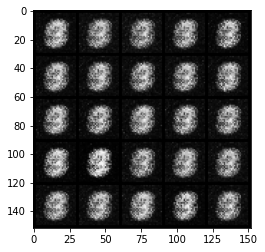

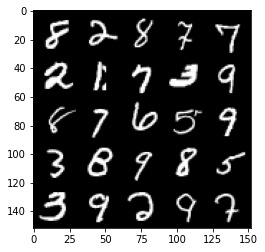

step 1000: Generator loss: 1.6660033676624302, discriminator loss: 0.3018181412220003


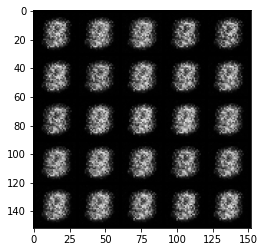

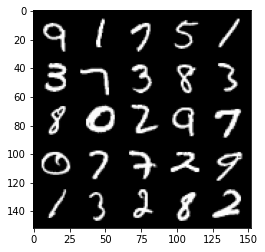

step 1500: Generator loss: 1.958306287050246, discriminator loss: 0.17598796531558036


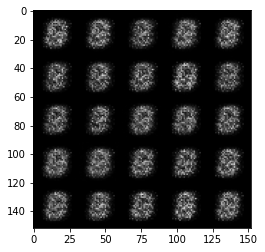

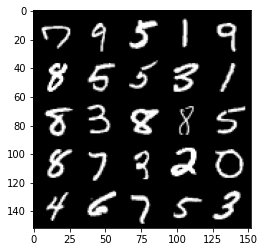

step 2000: Generator loss: 1.7627089858055114, discriminator loss: 0.19713690158724795


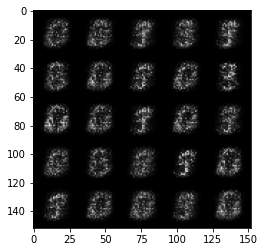

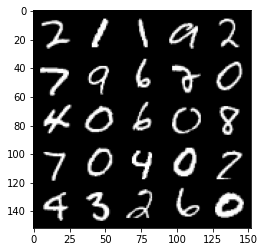

step 2500: Generator loss: 1.7456564953327163, discriminator loss: 0.19127317273616795


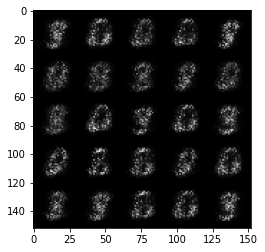

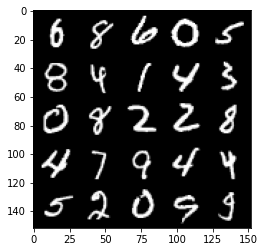

step 3000: Generator loss: 2.034736447095872, discriminator loss: 0.14861841401457787


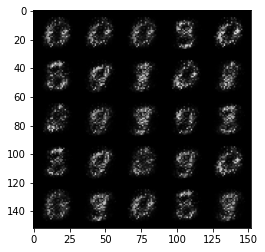

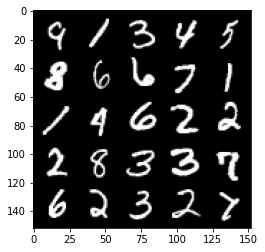

step 3500: Generator loss: 2.377990747451782, discriminator loss: 0.1330795280784369


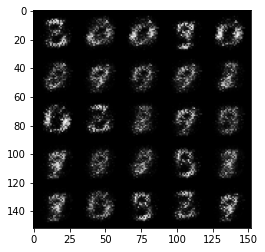

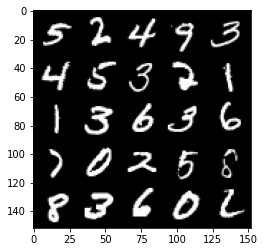

step 4000: Generator loss: 2.7216511535644545, discriminator loss: 0.11443038298189638


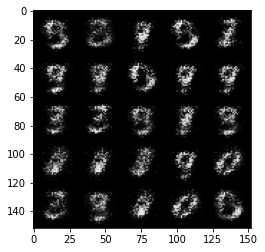

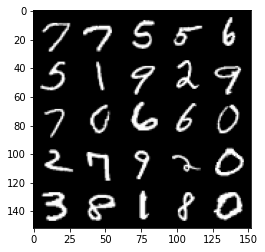

step 4500: Generator loss: 3.1472464790344254, discriminator loss: 0.10120828566700212


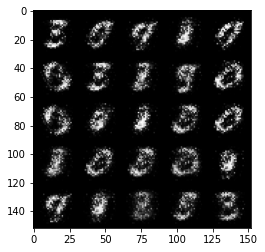

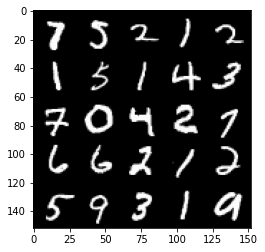

step 5000: Generator loss: 3.4565220637321468, discriminator loss: 0.08361117816716433


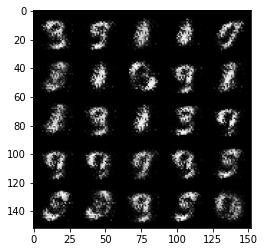

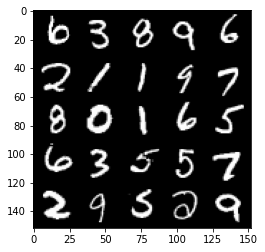

step 5500: Generator loss: 3.505041707038875, discriminator loss: 0.08615317443013182


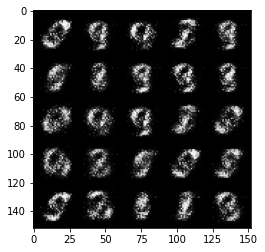

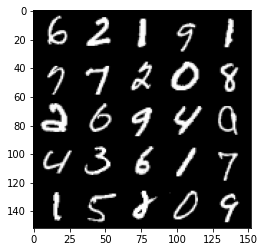

step 6000: Generator loss: 3.7584004163742075, discriminator loss: 0.07491180759668352


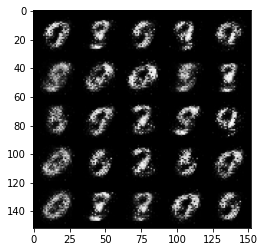

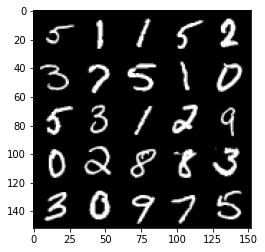

step 6500: Generator loss: 3.787825695514681, discriminator loss: 0.06361042229086163


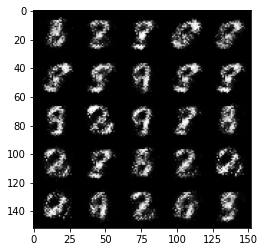

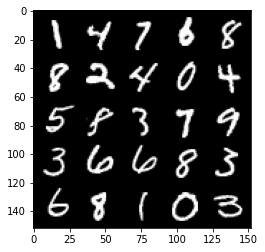

KeyboardInterrupt: ignored

In [15]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False

# image_tensor : the images to show

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        
        # upgrade discriminator
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        # update generator
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        
#         if test_generator:
#             try:
#                 assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch ==0)
#                 assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
#             except:
#                 error=True
#                 print("Runtime tests have failed")

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step >0:
            print(f"step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
                                  